Partie 1: Mécanique céleste

In [77]:
import numpy as np
from astropy.constants import G, M_earth, M_sun 
import matplotlib.pyplot as plt
import de421
from astropy.time import Time
from jplephem import Ephemeris

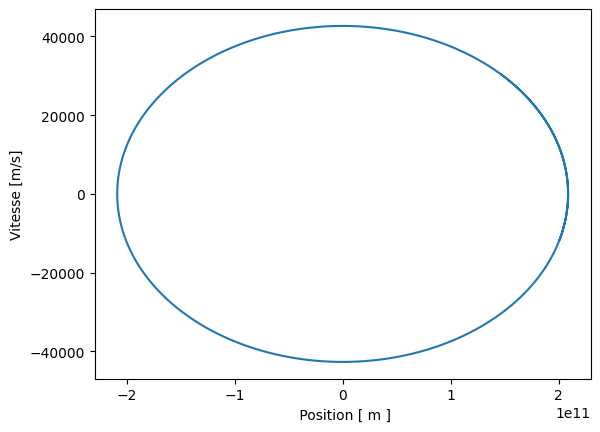

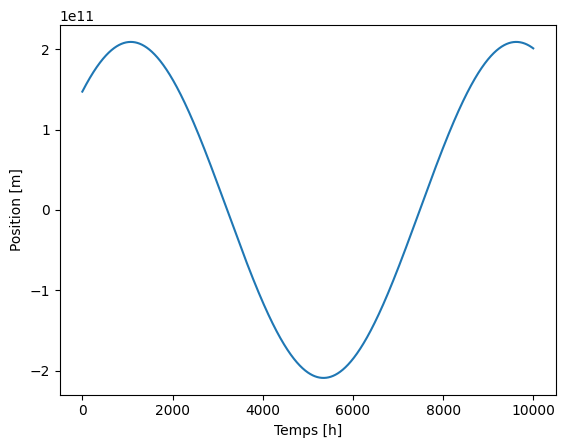

In [78]:
#a) Calcul de la méthode de Verlet
r_0 = 1.4710e11 # m
v_0 = 3.0287e4#m/s

def f(r):
    return(-G.value * M_sun.value * r/r_0**3)

def verlet(r_0, v_0, h, max):
    v_h = [v_0]
    r_h = [r_0]
    v_1 =  v_0 + 0.5 * h * f(r_0)
    r = r_0

    for i in range(1, max):
        r = r + h * v_1
        k = h * f(r)
        v_2 = v_1 + 0.5 * k 
        v_1 = v_1 + k
        v_h.append(v_2)
        r_h.append(r)
         

    return(v_h, r_h)

max = 10000
temps = [x for x in range(max)]
v_h, r_h = verlet(r_0, v_0, 3600, max)


plt.figure()
plt.plot(r_h, v_h)
plt.ylabel("Vitesse [m/s]")
plt.xlabel(" Position [ m ]")
plt.show()

plt.figure()
plt.plot(temps, r_h)
plt.ylabel("Position [m]")
plt.xlabel("Temps [h]")
plt.show()


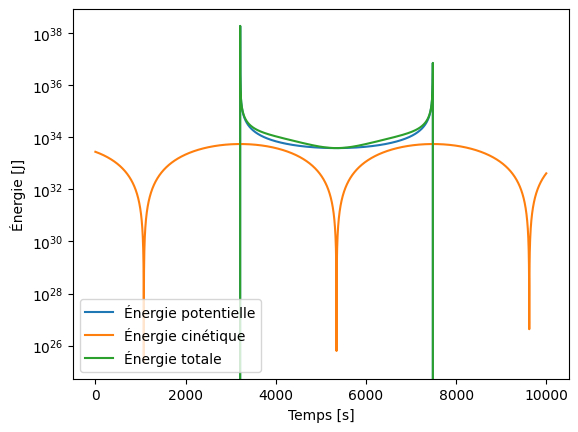

In [79]:
def verlet(r_0, v_0, h, max):
    v_h = [v_0]
    r_h = [r_0]
    U = [-G.value*M_sun.value*M_earth.value/r_0]
    E_k = [1/2*M_earth.value*v_0**2]
    E_tot = [U[0]+E_k[0]]
    
    v_1  =  v_0 + 0.5 * h * f(r_0)
    r = r_0

    for i in range(1, max):
        r = r + h * v_1
        if  abs(r) < 1000: 
            r = 1000
        k = h * f(r)
        v_2 = v_1 + 0.5 * k 
        v_1 = v_1 + k

        v_h.append(v_2)
        r_h.append(r)
 
        E_k.append(1/2*M_earth.value*v_2**2)
        U.append(-G.value*M_sun.value*M_earth.value/r)
        E_tot.append(U[i] + E_k[i])
    return(U, E_k, E_tot)


U, E_k, E_totVerlet = verlet(r_0, v_0, 3600, max)


plt.figure()
plt.semilogy(temps,U, label = "Énergie potentielle")
plt.semilogy(temps, E_k, label = "Énergie cinétique")
plt.semilogy(temps, E_totVerlet, label = "Énergie totale")
plt.ylabel("Énergie [J]")
plt.xlabel("Temps [s]")
plt.legend()
plt.show()

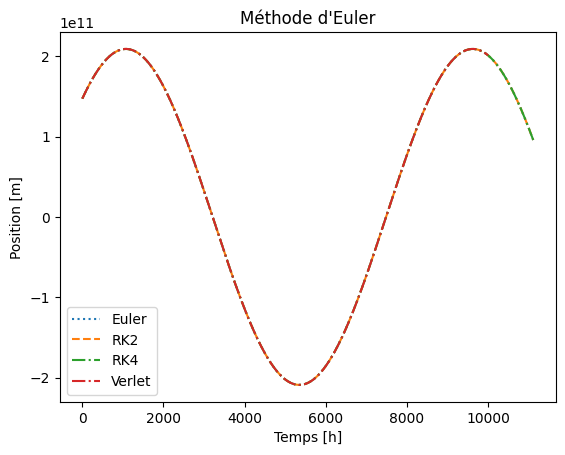

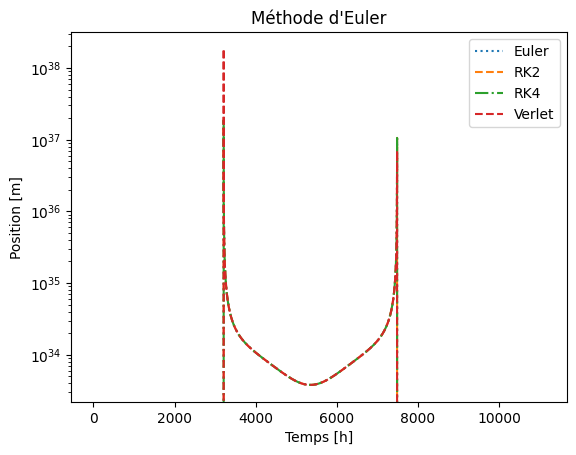

In [80]:
def Euler(a, b, h, r_0, v_0): 
    tpoints = np.arange(a,b,h)
    rpoints = []
    vpoints = []
    E_tot = []
    r = r_0 
    v = v_0
    for t in tpoints: 
        rpoints.append(r)
        vpoints.append(v)
        E_tot.append(-G.value*M_sun.value*M_earth.value/r + 1/2*M_earth.value*v**2)
        v += h * f(r)
        r = r + h*v
    return(rpoints, tpoints, vpoints, E_tot)

def RK2(a, b, h, r_0, v_0): 
    tpoints = np.arange(a,b,h)
    rpoints = []
    vpoints = []
    E_tot = []
    r = r_0 
    v = v_0
    for t in tpoints: 
        rpoints.append(r)
        vpoints.append(v)
        E_tot.append(-G.value*M_sun.value*M_earth.value/r + 1/2*M_earth.value*v**2)
        k1 = h * f(r)
        k2 = h * f(r+0.5*k1)
        v += k2
        r = r + h*v
    return(rpoints, tpoints, vpoints, E_tot)

def RK4(a, b, h, r_0, v_0): 
    tpoints = np.arange(a,b,h)
    rpoints = []
    vpoints = []
    E_tot = []
    r = r_0 
    v = v_0
    for t in tpoints: 
        rpoints.append(r)
        vpoints.append(v)
        E_tot.append(-G.value*M_sun.value*M_earth.value/r + 1/2*M_earth.value*v**2)
        k1 = h * f(r)
        k2 = h * f(r+0.5*k1)
        k3 = h*f(r+0.5*k2)
        k4 = h*f(r+k3)
        v += (k1+2*k2+2*k3+k4)/6
        r = r + h*v
    return(rpoints, tpoints, vpoints, E_tot)

rEuler,tEuler, vEuler, EEuler = Euler(0, 40000000, 3600, r_0, v_0)
rRK2,tRK2, vRK2, ERK2 = RK2(0, 40000000, 3600, r_0, v_0)
rRK4,tRK4, vRK4, ERK4 = RK4(0, 40000000, 3600, r_0, v_0)
temps = [x/3600 for x in tEuler]

plt.figure()
plt.title("Méthode d'Euler")
plt.ylabel("Position [m]")
plt.xlabel("Temps [h]")
plt.plot(temps,rEuler, label = "Euler", linestyle = "dotted")
plt.plot(temps,rRK2, label = "RK2", linestyle = "dashed")
plt.plot(temps,rRK4, label = "RK4", linestyle = "dashdot")
plt.plot(range(max),r_h, label = "Verlet", linestyle = "dashdot")
plt.legend()
plt.show()


plt.figure()
plt.title("Méthode d'Euler")
plt.ylabel("Position [m]")
plt.xlabel("Temps [h]")
plt.plot(temps,EEuler, label = "Euler", linestyle = "dotted")
plt.plot(temps,ERK2, label = "RK2", linestyle = "dashed")
plt.semilogy(temps,ERK4, label = "RK4", linestyle = "dashdot")
plt.semilogy(range(max),E_totVerlet, label = "Verlet", linestyle = "dashed")
plt.legend()
plt.show()



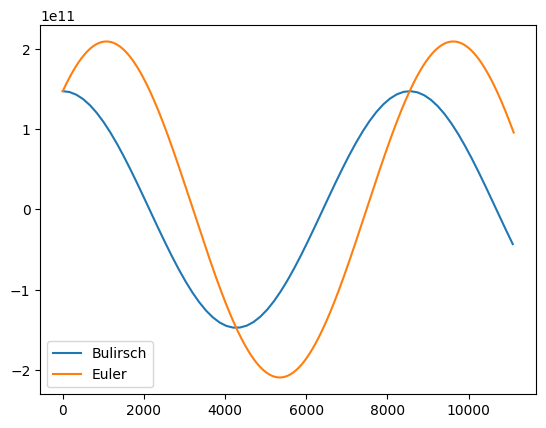

In [84]:
#d) Bulirsch-Stoer


def f(r):
    return((-G.value * M_sun.value * r/r_0**3)) 

def g(r):
    x = r[0]
    v = r[1]
    fx=v
    fv=f(x)
    return np.array([fx, fv],float)

def Bulirsch(a, b, H, r_0, v_0, delta):
    tpoints = np.arange(a, b, H)
    xpoints = []
    r = np.array([r_0, 0.0], float)
    
    for t in tpoints:
        xpoints.append(r[0])
        n = 1
        r1 = r+ 0.5*H*g(r)
        r2 = r + H*f(r1)

        R1 = np.empty([1,2],float)
        R1[0] = 0.5*(r1+r2+0.5*H*f(r2))

        error=2*H*delta
        while error > H*delta:
            n += 1
            h = H/n

            r1 = r + 0.5*h*g(r)
            r2 = r + h*g(r1)

            for i in range(n-1):
                r1 += h*g(r2)
                r2 += h*g(r1)
            R2 = R1
            R1 = np.empty([n,2], float)
            R1[0] = 0.5*(r1+r2+0.5*h*g(r2))

            for m in range (1, n):
                epsilon = (R1[m-1]-R2[m-1])/((n/(n-1))**(2*m)-1)
                R1[m] = R1[m-1] + epsilon 
            error = abs(epsilon[0])
        r = R1[n-1]              
    return(xpoints, tpoints)

r_0 = 1.4710e11 # m
v_0 = 3.0287e4 #m/s


rBur, tBur = Bulirsch(0, 40000000, 3600*24*7, r_0, v_0, 1000/(365*24*3600))
tBur = [x/3600 for x in tBur]

plt.plot(tBur, rBur, label = "Bulirsch")
plt.plot(temps, rEuler, label = "Euler")
plt.legend()
plt.show()
